<a href="https://colab.research.google.com/github/EmiLaPiola/TP-automatico-/blob/main/Tp_heuristicas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:

from google.colab import files
import zipfile
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Subí el archivo "dataset.zip"
uploaded = files.upload()

# Descomprimir en el directorio actual
with zipfile.ZipFile("datasetFinal.zip", "r") as zip_ref:
    zip_ref.extractall(".")  # Extrae "dataset_enviar/" en raíz

# Mostrar contenido de la carpeta extraída
print("Contenido de 'datasetFinal':")
print(os.listdir("datasetFinal"))


# Paso 2: Descomprimir "dataset.zip", que contiene la carpeta "dataset_enviar"

zip_path = "datasetFinal.zip"  # Nombre del archivo que subiste

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(".")  # Extrae la carpeta "dataset_enviar" dentro del entorno


# Paso 3: Verificar el contenido descomprimido (opcional)
print("Contenido de la carpeta datasetFinal:")
print(os.listdir("datasetFinal"))

# Paso 4: Cargar grafo e instancias

# Cargar el grafo
grafo = pd.read_csv("datasetFinal/grafo.csv", header=None)

# Cargar las 10 instancias
instancias = {}
for i in range(1, 11):
    path = f"datasetFinal/instancia{i}.csv"
    instancias[i] = pd.read_csv(path, header=None)

Saving datasetFinal.zip to datasetFinal (1).zip
Contenido de 'datasetFinal':
['instancia8.csv', 'instancia6.csv', 'instancia1.csv', 'instancia7.csv', 'grafo.csv', 'instancia10.csv', 'instancia4.csv', 'instancia9.csv', 'instancia3.csv', 'instancia5.csv', 'instancia2.csv', '.DS_Store']
Contenido de la carpeta datasetFinal:
['instancia8.csv', 'instancia6.csv', 'instancia1.csv', 'instancia7.csv', 'grafo.csv', 'instancia10.csv', 'instancia4.csv', 'instancia9.csv', 'instancia3.csv', 'instancia5.csv', 'instancia2.csv', '.DS_Store']


Nodos: 1200 | Arcos: 5446


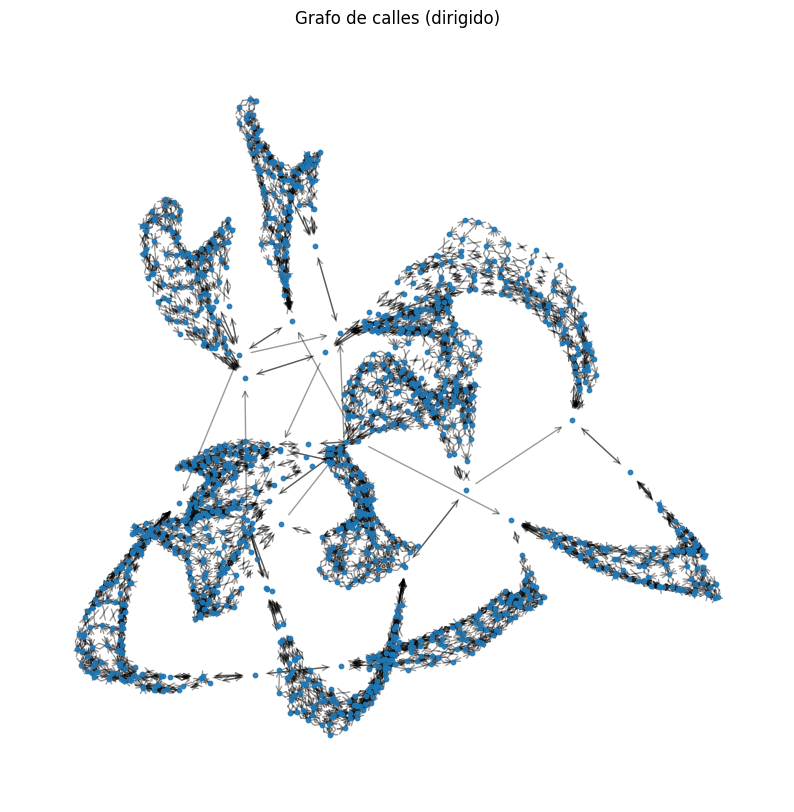

In [5]:
# Ruta corregida
GRAFO_PATH = "datasetFinal/grafo.csv"

# Cargar arcos: columnas (i, j, c_ij)
df_g = pd.read_csv(GRAFO_PATH, header=None, names=["u", "v", "w"])

# Crear grafo dirigido con pesos
G = nx.DiGraph()
for _, row in df_g.iterrows():
    G.add_edge(int(row.u), int(row.v), w=float(row.w))

print(f"Nodos: {G.number_of_nodes()} | Arcos: {G.number_of_edges()}")

# Layout (no basado en coordenadas geográficas)
pos = nx.spring_layout(G, seed=33)

# Dibujar el grafo
plt.figure(figsize=(10, 10))
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=10, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="#1f77b4", alpha=0.9)
# nx.draw_networkx_labels(G, pos, font_size=8)  # Descomentar si querés ver los números de nodo

plt.title("Grafo de calles (dirigido)")
plt.axis("off")
plt.show()

# Veamos como es la instancia 1

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


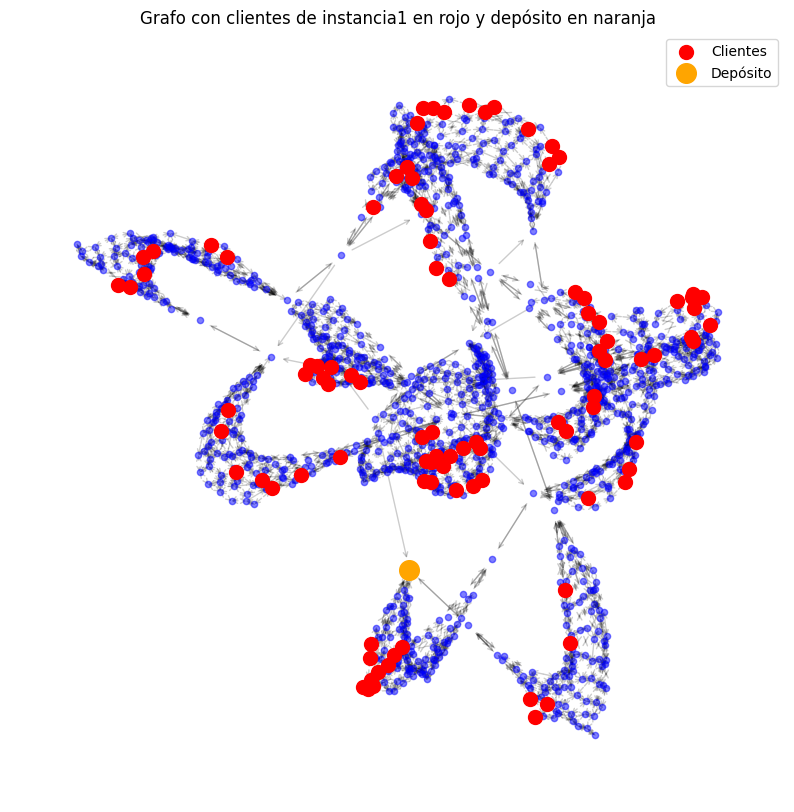

In [7]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Paths corregidos ---
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH = "datasetFinal/instancia1.csv"
DEPOT = 0  # nodo de la empresa

# --- Cargar grafo ---
df_g = pd.read_csv(GRAFO_PATH, header=None, names=["u","v","w"])
G = nx.DiGraph()
for _, row in df_g.iterrows():
    G.add_edge(int(row.u), int(row.v), w=float(row.w))

# --- Cargar clientes (hogares) ---
df_inst = pd.read_csv(INST_PATH, header=None, names=["home","radius"])
clientes = df_inst["home"].astype(int).tolist()

# --- Layout del grafo (si no hay coordenadas reales) ---
pos = nx.spring_layout(G, seed=42)

# --- Dibujo ---
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=20, node_color="blue", alpha=0.5)
nx.draw_networkx_nodes(G, pos, nodelist=clientes, node_size=100, node_color="red", label="Clientes")
if DEPOT in G.nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[DEPOT], node_size=200, node_color="orange", label="Depósito")
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=8, alpha=0.2)

plt.title("Grafo con clientes de instancia1 en rojo y depósito en naranja")
plt.axis("off")
plt.legend()
plt.show()

# IDEA PRINCIPAL : “ Vamos a la casa del trabajador más cercano ”:
La heurística de construcción planteada:

- Arrancamos en el depósito (nodo 0).

- Buscamos el trabajador más cercano al nodo actual (con Dijkstra).

- Recorremos el camino más corto válido hasta su casa, lo agregamos a la ruta y sumamos ese costo para ver al final cuanto nos costo todo el viaje.

- Marcamos al trabajador como atendido y repetimos desde esa casa hacia el siguiente más cercano.

- Al final la combi vuelve al depósito.

Porque creemos que es clave:

Hacemos un recorrido greedy: simplemente usamos Dijkstra desde el nodo actual y elegimos al cliente más cercano.

Simple de mejorar después con 2-opt, simulated annealing, etc.

Si despues lo combinamos con "solo ir a nodos desde los que el cliente puede caminar", podemos dejar de visitar una casa exacta y en cambio pasar por un nodo dentro de su ri.

# Fase de construcción (armar una solución inicial).

Trabajadores totales: 97
Levantados: 97
Costo total (suma de w): 16460.131
Ruta (nodos):
[0, 115, 474, 314, 143, 314, 243, 790, 553, 1119, 948, 419, 371, 741, 1072, 1017, 9, 1048, 9, 801, 665, 876, 917, 721, 147, 717, 1151, 751, 1051, 412, 1027, 610, 447, 458, 1130, 453, 931, 245, 361, 558, 865, 930, 985, 775, 363, 96, 306, 1006, 365, 25, 365, 368, 949, 1170, 1197, 951, 185, 123, 148, 1117, 921, 1190, 342, 806, 350, 497, 61, 288, 126, 683, 838, 1104, 874, 119, 874, 431, 354, 105, 627, 578, 695, 686, 625, 582, 360, 483, 564, 338, 1066, 854, 337, 1098, 237, 940, 331, 503, 809, 722, 263, 722, 139, 91, 64, 91, 52, 1038, 848, 454, 6, 537, 1068, 831, 505, 664, 505, 831, 1068, 548, 221, 339, 624, 1100, 1188, 634, 321, 212, 321, 1133, 1060, 609, 883, 78, 1004, 684, 780, 794, 327, 898, 327, 684, 681, 475, 1049, 127, 3, 678, 478, 993, 849, 797, 272, 252, 1110, 387, 488, 1102, 559, 897, 1192, 997, 272, 252, 770, 387, 7, 547, 753, 319, 851, 18, 294, 642, 1096, 1031, 716, 1031, 742, 529, 850, 820, 

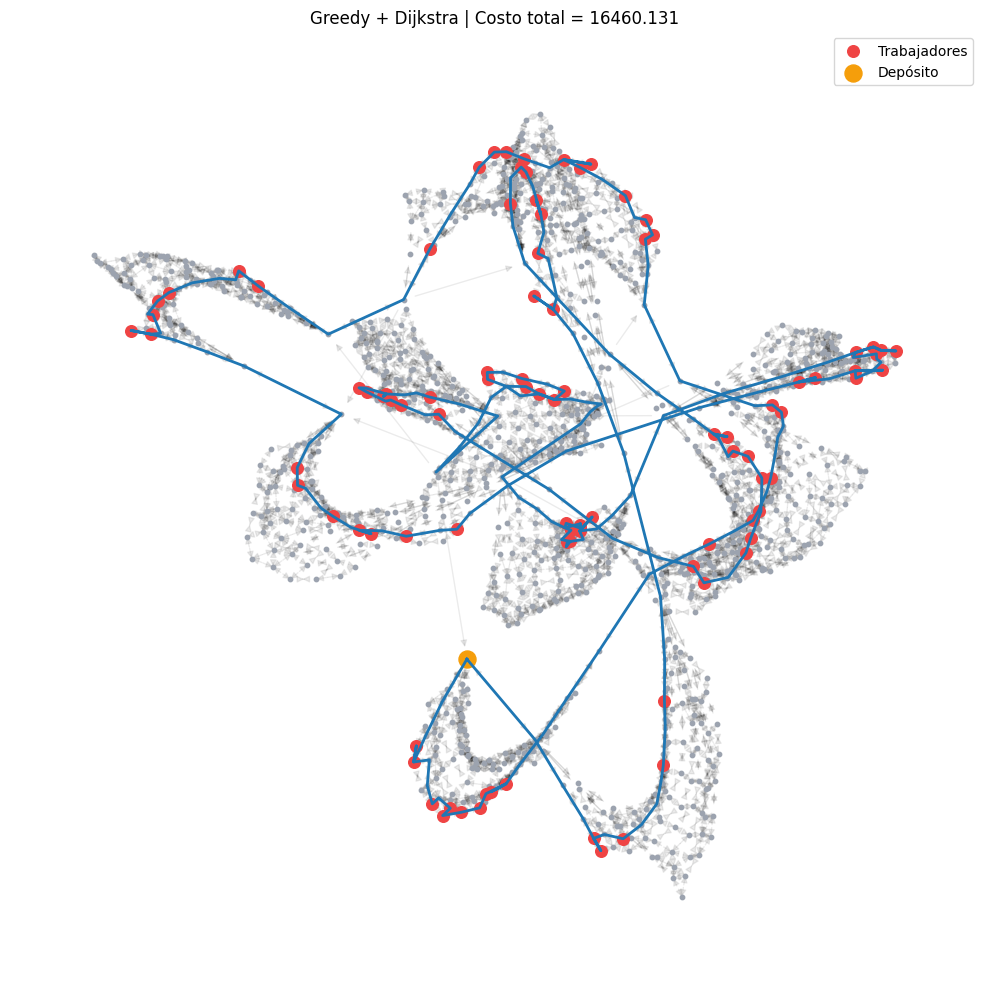

In [12]:
 # sin caminatas xd


"""
Greedy + Dijkstra (solo pesos):
- En cada iteración corre Dijkstra con corte temprano hasta el trabajador no visitado más barato.
- Concatena el camino mínimo válido y acumula el costo total.
- Al final, vuelve al depósito.
- Guarda resultados en CSV, PNG, y resultados1.txt (formato requerido).

Entradas:
  dataset_enviar/grafo.csv
  dataset_enviar/instancia1.csv

Salidas:
  ruta_dijkstra.csv
  segmentos_dijkstra.csv
  ruta_dijkstra.png (opcional)
  resultados1.txt
"""

import heapq
import random
import pandas as pd
from collections import defaultdict

# ---------------- Config ----------------
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH  = "datasetFinal/instancia1.csv"
DEPOT = 0
IS_DIRECTED = True
RETURN_TO_DEPOT = True
TIE_BREAK_RANDOM = True

HOME_COLS = ["home", "hogar", "node", "nodo", "cliente", "vi"]  # nombres posibles

# ---------------- Utilidades ----------------
def pick_col(df, candidates, alias="home"):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró columna para {alias}. Columnas: {list(df.columns)}")

def build_adj_with_weights(path, directed=True):
    df = pd.read_csv(path, header=None, names=["u", "v", "w"])
    adj = defaultdict(list)
    wmap = {}
    for _, r in df.iterrows():
        u, v, w = int(r.u), int(r.v), float(r.w)
        adj[u].append(v)
        wmap[(u, v)] = w
        if not directed:
            adj[v].append(u)
            wmap[(v, u)] = w
    return adj, wmap

def dijkstra_early(adj, wmap, src, targets_set):
    heap = [(0.0, src)]
    dist = {src: 0.0}
    parent = {src: None}
    best_cost = None
    found_targets = []

    while heap:
        du, u = heapq.heappop(heap)
        if du != dist[u]:
            continue
        if best_cost is not None and du > best_cost + 1e-12:
            break
        if u in targets_set:
            if best_cost is None:
                best_cost = du
            found_targets.append(u)
        for v in adj.get(u, []):
            nd = du + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(heap, (nd, v))

    if not found_targets:
        return None, None, None

    target = random.choice(found_targets) if (TIE_BREAK_RANDOM and len(found_targets) > 1) else found_targets[0]

    path = []
    cur = target
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return target, path, best_cost

# ---------------- Carga ----------------
adj, wmap = build_adj_with_weights(GRAFO_PATH, directed=IS_DIRECTED)

df_inst = pd.read_csv(INST_PATH, header=None, names=["home", "radius"])
home_col = pick_col(df_inst, HOME_COLS, alias="nodo del trabajador")
workers = [int(x) for x in df_inst[home_col].tolist()]
workers = [w for w in workers if w != DEPOT]
workers_set = set(workers)

if DEPOT not in adj and DEPOT not in workers_set:
    raise ValueError(f"El depósito {DEPOT} no existe en el grafo.")

# ---------------- Heurística ----------------
remaining = set(workers_set)
route = [DEPOT]
segments = []
unreachable = []

current = DEPOT
total_cost = 0.0

while remaining:
    target, path, seg_cost = dijkstra_early(adj, wmap, current, remaining)
    if target is None:
        unreachable.extend(sorted(list(remaining)))
        break
    route.extend(path[1:])
    segments.append({
        "from": current,
        "to": target,
        "segment_cost": float(seg_cost),
        "nodes": " ".join(map(str, path))
    })
    total_cost += float(seg_cost)
    remaining.remove(target)
    current = target

# Volver al depósito
if RETURN_TO_DEPOT:
    target, path, seg_cost = dijkstra_early(adj, wmap, current, {DEPOT})
    if target is not None:
        route.extend(path[1:])
        segments.append({
            "from": current,
            "to": DEPOT,
            "segment_cost": float(seg_cost),
            "nodes": " ".join(map(str, path))
        })
        total_cost += float(seg_cost)

# ---------------- Reporte y guardado ----------------
print(f"Trabajadores totales: {len(workers_set)}")
print(f"Levantados: {len(workers_set) - len(unreachable)}")
if unreachable:
    print(f"Inalcanzables: {sorted(unreachable)}")
print(f"Costo total (suma de w): {total_cost:.3f}")
print("Ruta (nodos):")
print(route)

# Formato pedido: resultados1.txt
with open("resultados1.txt", "w") as f:
    f.write(" ".join(map(str, route)))
print("Guardado: resultados1.txt")

# CSVs para análisis y debugging
pd.DataFrame({"step": range(len(route)), "node": route}).to_csv("ruta_dijkstra.csv", index=False)
pd.DataFrame(segments).to_csv("segmentos_dijkstra.csv", index=False)
print("Guardado: ruta_dijkstra.csv")
print("Guardado: segmentos_dijkstra.csv")

# ---------------- (Opcional) gráfico ----------------
try:
    import networkx as nx
    import matplotlib.pyplot as plt
    Gx = nx.DiGraph() if IS_DIRECTED else nx.Graph()
    for u, neighs in adj.items():
        for v in neighs:
            Gx.add_edge(u, v, w=wmap[(u, v)])
    pos = nx.spring_layout(Gx, seed=42)
    plt.figure(figsize=(10,10))
    nx.draw_networkx_edges(Gx, pos, alpha=0.08, arrows=IS_DIRECTED)
    nx.draw_networkx_nodes(Gx, pos, node_size=10, node_color="#9CA3AF")
    nx.draw_networkx_nodes(Gx, pos, nodelist=list(workers_set), node_size=70, node_color="#EF4444", label="Trabajadores")
    nx.draw_networkx_nodes(Gx, pos, nodelist=[DEPOT], node_size=150, node_color="#F59E0B", label="Depósito")

    xs = [pos[n][0] for n in route if n in pos]
    ys = [pos[n][1] for n in route if n in pos]
    plt.plot(xs, ys, linewidth=2)

    plt.title(f"Greedy + Dijkstra | Costo total = {total_cost:.3f}")
    plt.axis("off")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig("ruta_dijkstra.png", dpi=180)
    print("Guardado: ruta_dijkstra.png")
except Exception:
    print("No se pudo graficar la ruta.")

# Fase de construccion + caminatas


In [15]:
import heapq
import random
import pandas as pd
from collections import defaultdict

# Config
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH  = "datasetFinal/instancia1.csv"
DEPOT = 0
IS_DIRECTED = True
RETURN_TO_DEPOT = True
TIE_BREAK_RANDOM = True
HOME_COLS = ["home", "hogar", "node", "nodo", "cliente", "vi"]

# Utilidades
def pick_col(df, candidates, alias="home"):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró columna para {alias}. Columnas: {list(df.columns)}")

def build_adj_with_weights(path, directed=True):
    df = pd.read_csv(path, header=None, names=["u", "v", "w"])
    adj = defaultdict(list)
    wmap = {}
    for _, r in df.iterrows():
        u, v, w = int(r.u), int(r.v), float(r.w)
        adj[u].append(v)
        wmap[(u, v)] = w
        if not directed:
            adj[v].append(u)
            wmap[(v, u)] = w
    return adj, wmap

def bfs_radius(adj, wmap, start, radius):
    heap = [(0.0, start)]
    dist = {start: 0.0}
    result = set()
    while heap:
        d, u = heapq.heappop(heap)
        if d > radius + 1e-12:
            continue
        result.add(u)
        for v in adj.get(u, []):
            nd = d + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                heapq.heappush(heap, (nd, v))
    return result

def dijkstra_to_any(adj, wmap, src, target_nodes):
    heap = [(0.0, src)]
    dist = {src: 0.0}
    parent = {src: None}
    best_cost = None
    found_targets = []

    while heap:
        du, u = heapq.heappop(heap)
        if du != dist[u]:
            continue
        if best_cost is not None and du > best_cost + 1e-12:
            break
        if u in target_nodes:
            if best_cost is None:
                best_cost = du
            found_targets.append(u)
        for v in adj.get(u, []):
            nd = du + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(heap, (nd, v))

    if not found_targets:
        return None, None, None

    chosen = random.choice(found_targets) if (TIE_BREAK_RANDOM and len(found_targets) > 1) else found_targets[0]

    path = []
    cur = chosen
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return chosen, path, best_cost

# Carga
adj, wmap = build_adj_with_weights(GRAFO_PATH, directed=IS_DIRECTED)
df_inst = pd.read_csv(INST_PATH, header=None, names=["home", "radius"])
home_col = pick_col(df_inst, HOME_COLS, alias="nodo del trabajador")
workers_info = [(int(r[home_col]), float(r["radius"])) for _, r in df_inst.iterrows()]
workers_info = [(h, r) for h, r in workers_info if h != DEPOT]

# Precalcular caminata
worker_to_nodes = {}
for home, rad in workers_info:
    nodes = bfs_radius(adj, wmap, home, rad)
    worker_to_nodes[home] = nodes


remaining_workers = set(worker_to_nodes.keys())
route = [DEPOT]
segments = []
unreachable = []
current = DEPOT
total_cost = 0.0

while remaining_workers:
    candidate_nodes = set()
    node_to_workers = defaultdict(list)

    for w in remaining_workers:
        for n in worker_to_nodes[w]:
            candidate_nodes.add(n)
            node_to_workers[n].append(w)

    target_node, path, seg_cost = dijkstra_to_any(adj, wmap, current, candidate_nodes)
    if target_node is None:
        unreachable.extend(sorted(list(remaining_workers)))
        break



    route.extend(path[1:])
    segments.append({
        "from": current,
        "to": target_node,
        "segment_cost": float(seg_cost),
        "nodes": " ".join(map(str, path))
    })
    total_cost += float(seg_cost)
    current = target_node

    # Marcar todos los trabajadores posibles
    for w in node_to_workers[target_node]:
        if w in remaining_workers:
            remaining_workers.remove(w)

if RETURN_TO_DEPOT:
    t, path_back, cost_back = dijkstra_to_any(adj, wmap, current, {DEPOT})
    if t is not None:
        route.extend(path_back[1:])
        total_cost += float(cost_back)
        segments.append({
            "from": current,
            "to": DEPOT,
            "segment_cost": float(cost_back),
            "nodes": " ".join(map(str, path_back))
        })
        print(f"Volviendo al depósito desde {current} con costo {cost_back}")

print("\n--- Resultado final ---")
print(f"Trabajadores totales: {len(worker_to_nodes)}")
print(f"Atendidos: {len(worker_to_nodes) - len(unreachable)}")
if unreachable:
    print(f"Inalcanzables: {sorted(unreachable)}")
print(f"Costo total recorrido por la van: {total_cost:.3f}")
print("Ruta:", route)

Volviendo al depósito desde 628 con costo 1187.2959999999998

--- Resultado final ---
Trabajadores totales: 97
Atendidos: 97
Costo total recorrido por la van: 15054.523
Ruta: [0, 115, 474, 323, 243, 790, 1119, 515, 995, 298, 124, 665, 876, 917, 721, 400, 330, 689, 621, 649, 631, 1184, 102, 675, 479, 846, 245, 361, 558, 1082, 1009, 363, 96, 306, 1006, 368, 949, 837, 185, 123, 148, 1117, 921, 1190, 342, 350, 1025, 952, 61, 891, 193, 1050, 517, 1104, 431, 354, 105, 627, 578, 695, 625, 582, 747, 881, 1066, 404, 1024, 237, 940, 331, 503, 809, 722, 139, 706, 1038, 848, 454, 646, 537, 548, 221, 339, 624, 1100, 403, 1196, 1133, 1060, 244, 609, 883, 78, 1004, 684, 681, 475, 1049, 127, 3, 678, 1162, 603, 369, 470, 167, 252, 770, 387, 7, 547, 753, 319, 851, 18, 294, 642, 1109, 1128, 864, 820, 622, 597, 532, 972, 687, 762, 1002, 199, 16, 43, 428, 903, 58, 72, 824, 498, 1187, 761, 877, 920, 1115, 938, 984, 725, 784, 960, 73, 70, 1065, 113, 975, 444, 335, 44, 909, 94, 1034, 628, 598, 750, 636, 734, 

¿Qué hace actualmente tu heurística?

Cada trabajador tiene un radio de caminata.

Calculás todos los nodos que cada trabajador puede alcanzar caminando.

Mientras queden trabajadores sin atender:

Buscás todos los nodos que pueden atender al menos a un trabajador.

Usás Dijkstra desde la posición actual de la van hasta el nodo alcanzable más cercano.

Cuando llegás a ese nodo, todos los trabajadores que puedan caminar hasta ahí son atendidos.

Finalmente, la van vuelve al depósito.

Guardado: ruta_con_caminatas.png


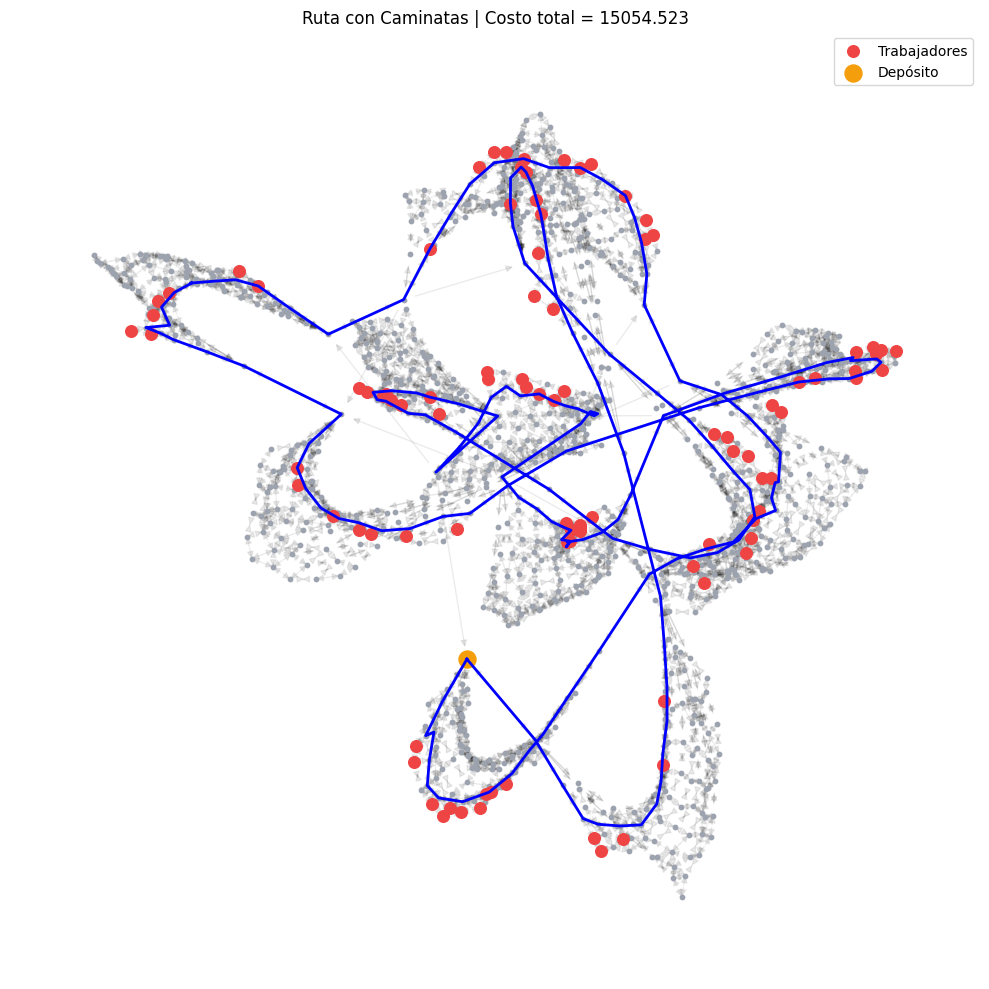

In [17]:
try:
    import networkx as nx
    import matplotlib.pyplot as plt

    Gx = nx.DiGraph() if IS_DIRECTED else nx.Graph()
    for u, neighs in adj.items():
        for v in neighs:
            Gx.add_edge(u, v, w=wmap[(u, v)])

    pos = nx.spring_layout(Gx, seed=42)  # You can change layout if needed

    plt.figure(figsize=(10, 10))

    # Draw all edges faintly
    nx.draw_networkx_edges(Gx, pos, alpha=0.08, arrows=IS_DIRECTED)

    # Draw all nodes
    nx.draw_networkx_nodes(Gx, pos, node_size=10, node_color="#9CA3AF")

    # Workers (excluding depot)
    worker_nodes = list(worker_to_nodes.keys())
    if DEPOT in worker_nodes:
        worker_nodes.remove(DEPOT)
    nx.draw_networkx_nodes(Gx, pos, nodelist=worker_nodes, node_size=70, node_color="#EF4444", label="Trabajadores")

    # Depot
    nx.draw_networkx_nodes(Gx, pos, nodelist=[DEPOT], node_size=150, node_color="#F59E0B", label="Depósito")

    # Path followed by the van
    xs = [pos[n][0] for n in route if n in pos]
    ys = [pos[n][1] for n in route if n in pos]
    plt.plot(xs, ys, linewidth=2, color="blue")

    plt.title(f"Ruta con Caminatas | Costo total = {total_cost:.3f}")
    plt.axis("off")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig("ruta_con_caminatas.png", dpi=180)
    print("Guardado: ruta_con_caminatas.png")

except Exception as e:
    print("No se pudo graficar la ruta.")
    print("Error:", e)


# Fase de mejoras

 - Podemos hacer 2 opt ( no mejora nada, no sabemos porque )
 - Podemos hacer algoritmo genetico ( tarda mucho en correr, ver mejoras )




In [41]:
import heapq
import random
import pandas as pd
from collections import defaultdict

# Config
GRAFO_PATH = "datasetFinal/grafo.csv"
INST_PATH  = "datasetFinal/instancia1.csv"
DEPOT = 0
IS_DIRECTED = True
RETURN_TO_DEPOT = True
TIE_BREAK_RANDOM = True
HOME_COLS = ["home", "hogar", "node", "nodo", "cliente", "vi"]

# Utilidades
def pick_col(df, candidates, alias="home"):
    for c in candidates:
        if c in df.columns:
            return c
    raise ValueError(f"No se encontró columna para {alias}. Columnas: {list(df.columns)}")

def build_adj_with_weights(path, directed=True):
    df = pd.read_csv(path, header=None, names=["u", "v", "w"])
    adj = defaultdict(list)
    wmap = {}
    for _, r in df.iterrows():
        u, v, w = int(r.u), int(r.v), float(r.w)
        adj[u].append(v)
        wmap[(u, v)] = w
        if not directed:
            adj[v].append(u)
            wmap[(v, u)] = w
    return adj, wmap

def bfs_radius(adj, wmap, start, radius):
    heap = [(0.0, start)]
    dist = {start: 0.0}
    result = set()
    while heap:
        d, u = heapq.heappop(heap)
        if d > radius + 1e-12:
            continue
        result.add(u)
        for v in adj.get(u, []):
            nd = d + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                heapq.heappush(heap, (nd, v))
    return result

def dijkstra_to_any(adj, wmap, src, target_nodes):
    heap = [(0.0, src)]
    dist = {src: 0.0}
    parent = {src: None}
    best_cost = None
    found_targets = []

    while heap:
        du, u = heapq.heappop(heap)
        if du != dist[u]:
            continue
        if best_cost is not None and du > best_cost + 1e-12:
            break
        if u in target_nodes:
            if best_cost is None:
                best_cost = du
            found_targets.append(u)
        for v in adj.get(u, []):
            nd = du + wmap[(u, v)]
            if v not in dist or nd < dist[v] - 1e-12:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(heap, (nd, v))

    if not found_targets:
        return None, None, None

    chosen = random.choice(found_targets) if (TIE_BREAK_RANDOM and len(found_targets) > 1) else found_targets[0]

    path = []
    cur = chosen
    while cur is not None:
        path.append(cur)
        cur = parent[cur]
    path.reverse()
    return chosen, path, best_cost

# Carga
adj, wmap = build_adj_with_weights(GRAFO_PATH, directed=IS_DIRECTED)
df_inst = pd.read_csv(INST_PATH, header=None, names=["home", "radius"])
home_col = pick_col(df_inst, HOME_COLS, alias="nodo del trabajador")
workers_info = [(int(r[home_col]), float(r["radius"])) for _, r in df_inst.iterrows()]
workers_info = [(h, r) for h, r in workers_info if h != DEPOT]

# Precalcular caminata
worker_to_nodes = {}
for home, rad in workers_info:
    nodes = bfs_radius(adj, wmap, home, rad)
    worker_to_nodes[home] = nodes


remaining_workers = set(worker_to_nodes.keys())
route = [DEPOT]
segments = []
unreachable = []
current = DEPOT
total_cost = 0.0

while remaining_workers:
    candidate_nodes = set()
    node_to_workers = defaultdict(list)

    for w in remaining_workers:
        for n in worker_to_nodes[w]:
            candidate_nodes.add(n)
            node_to_workers[n].append(w)

    target_node, path, seg_cost = dijkstra_to_any(adj, wmap, current, candidate_nodes)
    if target_node is None:
        unreachable.extend(sorted(list(remaining_workers)))
        break



    route.extend(path[1:])
    segments.append({
        "from": current,
        "to": target_node,
        "segment_cost": float(seg_cost),
        "nodes": " ".join(map(str, path))
    })
    total_cost += float(seg_cost)
    current = target_node

    # Marcar todos los trabajadores posibles
    for w in node_to_workers[target_node]:
        if w in remaining_workers:
            remaining_workers.remove(w)

if RETURN_TO_DEPOT:
    t, path_back, cost_back = dijkstra_to_any(adj, wmap, current, {DEPOT})
    if t is not None:
        route.extend(path_back[1:])
        total_cost += float(cost_back)
        segments.append({
            "from": current,
            "to": DEPOT,
            "segment_cost": float(cost_back),
            "nodes": " ".join(map(str, path_back))
        })
        print(f"Volviendo al depósito desde {current} con costo {cost_back}")

print("\n--- Resultado final ---")
print(f"Trabajadores totales: {len(worker_to_nodes)}")
print(f"Atendidos: {len(worker_to_nodes) - len(unreachable)}")
if unreachable:
    print(f"Inalcanzables: {sorted(unreachable)}")
print(f"Costo total recorrido por la van: {total_cost:.3f}")
print("Ruta:", route)




Volviendo al depósito desde 628 con costo 1187.2959999999998

--- Resultado final ---
Trabajadores totales: 97
Atendidos: 97
Costo total recorrido por la van: 15054.523
Ruta: [0, 115, 474, 323, 243, 790, 1119, 515, 995, 298, 124, 665, 876, 917, 721, 400, 330, 689, 621, 649, 631, 1184, 102, 675, 479, 846, 245, 361, 558, 1082, 1009, 363, 96, 306, 1006, 368, 949, 837, 185, 123, 148, 1117, 921, 1190, 342, 350, 1025, 952, 61, 891, 193, 1050, 517, 1104, 431, 354, 105, 627, 578, 695, 625, 582, 747, 881, 1066, 404, 1024, 237, 940, 331, 503, 809, 722, 139, 706, 1038, 848, 454, 646, 537, 548, 221, 339, 624, 1100, 403, 1196, 1133, 1060, 244, 609, 883, 78, 1004, 684, 681, 475, 1049, 127, 3, 678, 1162, 603, 369, 470, 167, 252, 770, 387, 7, 547, 753, 319, 851, 18, 294, 642, 1109, 1128, 864, 820, 622, 597, 532, 972, 687, 762, 1002, 199, 16, 43, 428, 903, 58, 72, 824, 498, 1187, 761, 877, 920, 1115, 938, 984, 725, 784, 960, 73, 70, 1065, 113, 975, 444, 335, 44, 909, 94, 1034, 628, 598, 750, 636, 734, 

# Ruteo con variante de penalizacion


- Correr la heuristica  inicial  y obtener costo original atendiendo a todos.

Para cada trabajador i:
- Simular la ruta sin atender a i.
- Penalizar con un valor P.
- Calcular el nuevo costo: costo_ruta_sin_i + P.
- Si ese costo es menor que el original, guardar la solución.
- Repetir quitando más trabajadores, hasta que el costo total deje de mejorar.
COMPLETAR
